<a href="https://colab.research.google.com/github/Viswanathan25/Singapore-Flat-Prices-Prediction/blob/main/S_pre_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [42]:
# First, we observe the dataset and determine which dataset is relevant to our analysis.
hdb_df = pd.read_csv("/content/ResaleflatpricesbasedonregistrationdatefromJan2017onwards (1).csv")
hdb_df.head(10)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0
5,2017-01,ANG MO KIO,3 ROOM,150,ANG MO KIO AVE 5,01 TO 03,68.0,New Generation,1981,63 years,275000.0
6,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,280000.0
7,2017-01,ANG MO KIO,3 ROOM,218,ANG MO KIO AVE 1,04 TO 06,67.0,New Generation,1976,58 years 04 months,285000.0
8,2017-01,ANG MO KIO,3 ROOM,447,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1979,61 years 06 months,285000.0
9,2017-01,ANG MO KIO,3 ROOM,571,ANG MO KIO AVE 3,01 TO 03,67.0,New Generation,1979,61 years 04 months,285000.0


In [43]:
# In my analysis, I do not consider street name, block and  flat model is relevant (town is sufficient for analysis, as no description of impact of the address, e.g., near MRT or not). Some information in flat model are either similar to room type (2 room, multi generation, etc.) or it reflected how old the unit is, which can be represented by lease commence date and remaining lease.Therefore. I will drop this column for my analysis
hdb_df = hdb_df.drop(['month','street_name','flat_model','lease_commence_date', 'block'], axis=1)

In [44]:
# Let's rename the column so it will be clearer
hdb_df = hdb_df.rename(columns={'flat_type':'number_of_rooms','storey_range':'storey'})

In [45]:
# I assume EXECUTIVE is equal to a 6 room (5 room + 1 study room). MULTI-GENERATION is equal to a 5 room (it served the same purpose).
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'EXECUTIVE','6 ROOM',regex=True)
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'MULTI-GENERATION','5 ROOM',regex=True)
hdb_df['number_of_rooms'] = hdb_df['number_of_rooms'].str.replace(r'ROOM','',regex=True).astype('int')

In [46]:
# I assume that rather we use floor range, I the possible highest floor within the unit storey range.
hdb_df['storey'] = hdb_df['storey'].str[-2:].astype('int')

In [47]:
#I revise the format of the data in the remaining lease to be quantifiable (change to float).
hdb_df['remaining_lease'] = hdb_df['remaining_lease'].str.split(' ')
hdb_df['remaining_lease'] = hdb_df['remaining_lease'].apply(lambda x: (float(x[0])+(float(x[2])/12)) if (len(x)==4) else float(x[0]))
hdb_df.head()

,town,number_of_rooms,storey,floor_area_sqm,remaining_lease,resale_price
0,ANG MO KIO,2,12,44.0,61.333333,232000.0
1,ANG MO KIO,3,3,67.0,60.583333,250000.0
2,ANG MO KIO,3,3,67.0,62.416667,262000.0
3,ANG MO KIO,3,6,68.0,62.083333,265000.0
4,ANG MO KIO,3,3,67.0,62.416667,265000.0


In [48]:
# Observe whether there is missing data or not.
hdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172213 entries, 0 to 172212
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   town             172213 non-null  object 
 1   number_of_rooms  172213 non-null  int64  
 2   storey           172213 non-null  int64  
 3   floor_area_sqm   172213 non-null  float64
 4   remaining_lease  172213 non-null  float64
 5   resale_price     172213 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 7.9+ MB


In [49]:
hdb_df.isna().sum()

town               0
number_of_rooms    0
storey             0
floor_area_sqm     0
remaining_lease    0
resale_price       0
dtype: int64

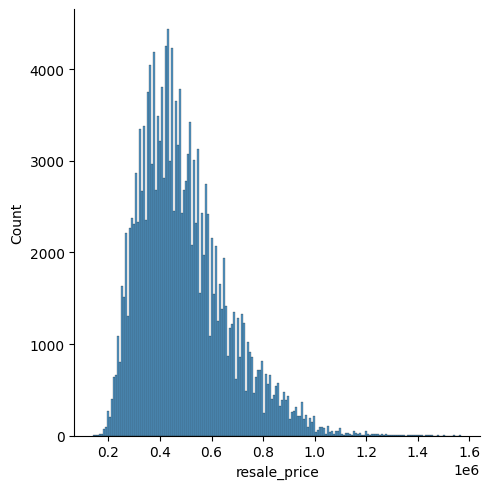

In [50]:
# First, we want to se ethe distribution of HDB resale price in Singapore
sns.displot(hdb_df['resale_price'])

In [51]:
# Let see the statistic information of the data
hdb_df.describe()

,number_of_rooms,storey,floor_area_sqm,remaining_lease,resale_price
count,172213.000000,172213.000000,172213.000000,172213.000000,1.722130e+05
mean,4.128091,9.768026,97.254352,74.671981,4.927507e+05
std,0.917051,5.947057,24.019944,13.879601,1.706012e+05
min,1.000000,3.000000,31.000000,41.750000,1.400000e+05
25%,3.000000,6.000000,82.000000,63.333333,3.680000e+05
50%,4.000000,9.000000,93.000000,74.583333,4.610000e+05
75%,5.000000,12.000000,112.000000,88.083333,5.850000e+05
max,6.000000,51.000000,249.000000,97.750000,1.568888e+06


<Axes: >

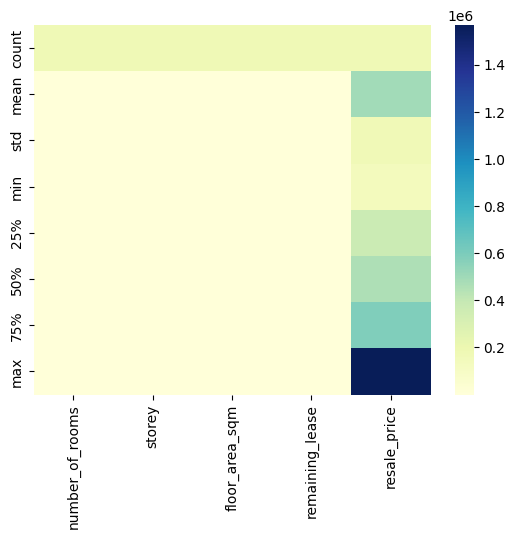

In [12]:
# Let us see the relation between each parameters
sns.heatmap(hdb_df.describe(), cmap="YlGnBu")

In [52]:
hdb_df['town'].unique()

array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', 'MARINE PARADE', 'PASIR RIS', 'PUNGGOL',
       'QUEENSTOWN', 'SEMBAWANG', 'SENGKANG', 'SERANGOON', 'TAMPINES',
       'TOA PAYOH', 'WOODLANDS', 'YISHUN'], dtype=object)

In [53]:
hdb_df = hdb_df.replace(dict.fromkeys(['SEMBAWANG','SENGKANG','WOODLANDS','YISHUN'], 'NORTH'))
hdb_df = hdb_df.replace(dict.fromkeys(['BUKIT MERAH','BUKIT TIMAH','QUEENSTOWN'], 'SOUTH'))
hdb_df = hdb_df.replace(dict.fromkeys(['BEDOK','GEYLANG','HOUGANG','KALLANG/WHAMPOA','PASIR RIS','PUNGGOL','SERANGOON','TAMPINES'], 'EAST'))
hdb_df = hdb_df.replace(dict.fromkeys(['BUKIT BATOK','BUKIT PANJANG','CHOA CHU KANG','CLEMENTI','JURONG EAST','JURONG WEST'], 'WEST'))
hdb_df = hdb_df.replace(dict.fromkeys(['ANG MO KIO','CENTRAL AREA','BISHAN','MARINE PARADE','TOA PAYOH'], 'CENTRAL'))

In [54]:
hdb_df = hdb_df.rename(columns={'town':'region'})

In [55]:
X = hdb_df.iloc[:,:-1].values
y = hdb_df.iloc[:,-1].values

In [56]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [63]:
X.shape,y.shape

((172213, 9), (172213,))

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [65]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((137770, 9), (34443, 9), (137770,), (34443,))

In [58]:
# Import neccessary library to evaluate the performance of each machine learning model
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

In [20]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_ypred = mlr.predict(X_test)
mlr_acc = r2_score(y_test,mlr_ypred)
mlr_acc

0.6571368135162412

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
# Let's determine the best degree for polynomial
for n in range(2,5):
    poly_reg = PolynomialFeatures(degree = n)
    X_poly = poly_reg.fit_transform(X_train)
    pr = LinearRegression()
    pr.fit(X_poly, y_train)
    poly_ypred = pr.predict(poly_reg.transform(X_test))
    poly_acc = r2_score(y_test,poly_ypred)
    poly_rmse = np.sqrt(mean_squared_error(y_test,poly_ypred))
    print(r'The accuracy of polynomial regression with degree of {} is {}'.format(n,poly_acc))
    print(r'The RMSE of polynomial regression with degree of {} is {}'.format(n,poly_rmse))

The accuracy of polynomial regression with degree of 2 is 0.7241638547694914
The RMSE of polynomial regression with degree of 2 is 89142.73461100546
The accuracy of polynomial regression with degree of 3 is 0.7367541730917715
The RMSE of polynomial regression with degree of 3 is 87084.55016857812
The accuracy of polynomial regression with degree of 4 is 0.7488965085433121
The RMSE of polynomial regression with degree of 4 is 85052.43288253681


In [22]:
from sklearn.linear_model import Ridge
ridge_r = Ridge()
ridge_r.fit(X_train, y_train)
ridge_ypred = ridge_r.predict(X_test)
ridge_acc = r2_score(y_test,ridge_ypred)
ridge_acc

0.6571368166133151

In [23]:
from sklearn.linear_model import Lasso
lasso_r = Lasso(max_iter=100000)
lasso_r.fit(X_train, y_train)
lasso_ypred = lasso_r.predict(X_test)
lasso_acc = r2_score(y_test,lasso_ypred)
lasso_acc

0.6571367876890737

In [24]:
from sklearn.linear_model import ElasticNet
EN_r = ElasticNet()
EN_r.fit(X_train, y_train)
EN_ypred = EN_r.predict(X_test)
EN_acc = r2_score(y_test,EN_ypred)
EN_acc

0.5660991507116963

In [25]:
from sklearn.tree import DecisionTreeRegressor
tree_r = DecisionTreeRegressor()
tree_r.fit(X_train, y_train)
tree_ypred = tree_r.predict(X_test)
tree_acc = r2_score(y_test,tree_ypred)
tree_acc

0.7384655739987871

In [26]:
from sklearn.ensemble import RandomForestRegressor
forest_r = RandomForestRegressor(n_estimators = 10)
forest_r.fit(X_train, y_train)
forest_ypred = forest_r.predict(X_test)
forest_acc = r2_score(y_test,forest_ypred)
forest_acc

0.7994313246773044

<ipython-input-27-733e2c8a88d4>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1 = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
<ipython-input-27-733e2c8a88d4>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2 = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)


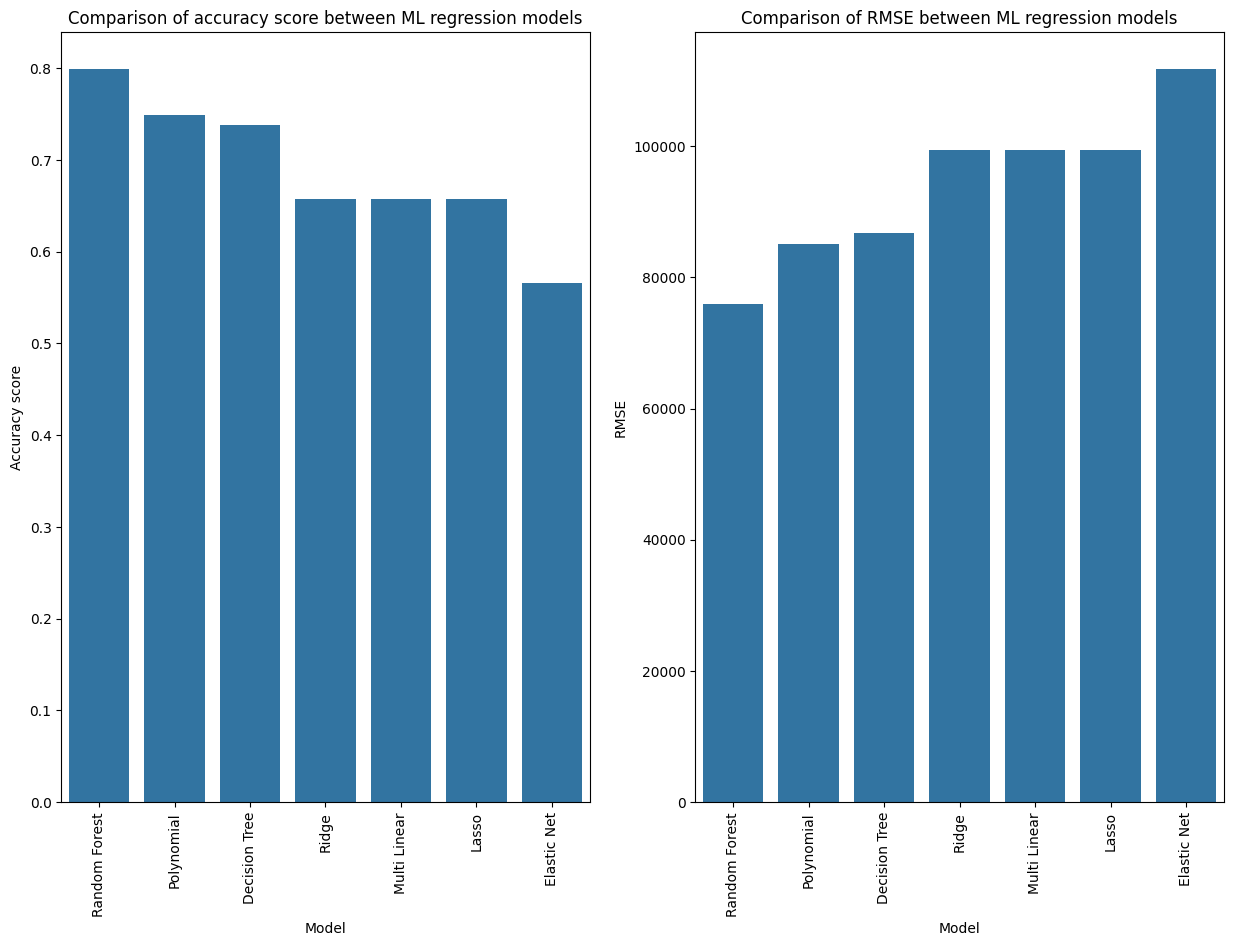

In [27]:
# Accuracy score for multi linear regression
mlr_acc = r2_score(y_test,mlr_ypred)
mlr_rmse = np.sqrt(mean_squared_error(y_test,mlr_ypred))
# Evaluation for polynomial regression has been calculated in finding the best degree
# Evaluation for ridge regression
ridge_acc = r2_score(y_test,ridge_ypred)
ridge_rmse = np.sqrt(mean_squared_error(y_test,ridge_ypred))
# Evaluation for lasso regression
lasso_acc = r2_score(y_test,lasso_ypred)
lasso_rmse = np.sqrt(mean_squared_error(y_test,lasso_ypred))
# Evaluation for elastic net regression
EN_acc = r2_score(y_test,EN_ypred)
EN_rmse = np.sqrt(mean_squared_error(y_test,EN_ypred))
# Evaluation for decision trees regression
tree_acc = r2_score(y_test,tree_ypred)
tree_rmse = np.sqrt(mean_squared_error(y_test,tree_ypred))
# Evaluation for elastic random forest regression
forest_acc = r2_score(y_test,forest_ypred)
forest_rmse = np.sqrt(mean_squared_error(y_test,forest_ypred))
# Let's put it as a list and compare it in a bar chart
model_acc_score = [mlr_acc,poly_acc, ridge_acc, lasso_acc, EN_acc, tree_acc, forest_acc]
model_rmse = [mlr_rmse, poly_rmse, ridge_rmse, lasso_rmse, EN_rmse, tree_rmse, forest_rmse]
model_list = ['Multi Linear', 'Polynomial', 'Ridge', 'Lasso', 'Elastic Net', 'Decision Tree', 'Random Forest']
model_result_df = pd.DataFrame(
    {'Model': model_list,
     'Accuracy score': model_acc_score,
     'RMSE': model_rmse
    })
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
sns.barplot(data=model_result_df, x='Model', y='Accuracy score', ax=ax1,order=model_result_df.sort_values('Accuracy score',ascending = False).Model).set_title("Comparison of accuracy score between ML regression models")
ax1 = ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
sns.barplot(data=model_result_df, x='Model', y='RMSE', ax=ax2, order=model_result_df.sort_values('RMSE').Model).set_title("Comparison of RMSE between ML regression models")
ax2 = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

In [28]:
# We know that after One Hot Encoding, the value of Central, East, North, South, and West is one at column 1,2,3,4, and 5, respectively (following alphabetical order).
area = ['Central','East','North','South','West']
pred_price_central = forest_r.predict([[1.0, 0.0, 0.0, 0.0, 0.0, 4, 9, 95.0, 75]])[0]
pred_price_east = forest_r.predict([[0.0, 1.0, 0.0, 0.0, 0.0, 4, 9, 95.0, 75]])[0]
pred_price_north = forest_r.predict([[0.0, 0.0, 1.0, 0.0, 0.0, 4, 9, 95.0, 75]])[0]
pred_price_south = forest_r.predict([[0.0, 0.0, 0.0, 1.0, 0.0, 4, 9, 95.0, 75]])[0]
pred_price_west = forest_r.predict([[0.0, 0.0, 0.0, 0.0, 1.0, 4, 9, 95.0, 75]])[0]
resale_price = [pred_price_central,pred_price_east,pred_price_north,pred_price_south,pred_price_west]
predict_df = pd.DataFrame(list(zip(area, resale_price)),
              columns=['Area','Predicted HDB price (SGD)'])
predict_df.round()

,Area,Predicted HDB price (SGD)
0,Central,736300.0
1,East,652466.0
2,North,457600.0
3,South,799100.0
4,West,513000.0


In [ ]:
hdb_df

,region,number_of_rooms,storey,floor_area_sqm,remaining_lease,resale_price
0,CENTRAL,2,12,44.0,61.333333,232000.0
1,CENTRAL,3,3,67.0,60.583333,250000.0
2,CENTRAL,3,3,67.0,62.416667,262000.0
3,CENTRAL,3,6,68.0,62.083333,265000.0
4,CENTRAL,3,3,67.0,62.416667,265000.0
...,...,...,...,...,...,...
172208,NORTH,5,12,112.0,90.666667,620000.0
172209,NORTH,5,3,112.0,90.833333,630000.0
172210,NORTH,5,6,112.0,93.083333,690000.0
172211,NORTH,6,9,146.0,62.833333,935000.0


In [ ]:
hdb_df.to_csv('fin1.csv',index=False)

In [66]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 10)

model.fit(X_train,y_train)
y_pre_train = model.predict(X_train)
y_pre_test = model.predict(X_test)

#r2 score prediction
r2_train = r2_score(y_train, y_pre_train)
r2_test = r2_score(y_test, y_pre_test)

print(f'Training_r2_score: {r2_train}, Testing_r2_score: {r2_test}')

Training_r2_score: 0.9259928058096385, Testing_r2_score: 0.7982311236227848


In [67]:
model.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10)

In [ ]:
predicted = model.predict([X[100].tolist()])
predicted[0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


393556.4285714286

In [69]:
import pickle
with open('Sr4_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

In [70]:
with open("/content/Sr4_regression.pkl", 'rb') as f:
  model = pickle.load(f)


In [71]:
model

RandomForestRegressor(n_estimators=10)

In [72]:
X[1000].tolist()

[1.0, 0.0, 0.0, 0.0, 0.0, 3, 12, 66.0, 52.583333333333336]

In [73]:
y[1000].tolist()

268000.0

In [74]:
predicted = model.predict([X[1000].tolist()])
predicted[0]

255500.0

In [ ]:
                                                                    END